In [50]:
import json
import torch

from pathlib import Path
from typing import Union
from PIL import Image

from torch.utils.data import Dataset
from torchvision.transforms import transforms

from transformers import AutoTokenizer
from transformers.tokenization_utils import PreTrainedTokenizer


class WikiTextMaskedDataset(Dataset):
    """
    Dataset for pre-training models on synthetic images based on WikiText.
    """
    DEFAULT_TRANSFORMS = transforms.Resize((600, 300))
    RANDOM_TRANSFORMS = transforms.RandomApply(torch.nn.ModuleList([
        transforms.GaussianBlur(3),
        transforms.ColorJitter(),
        transforms.RandomRotation(degrees=(-5, 5)),
    ]), p=0.5)

    def __init__(self,
                 dataset_dir: str,
                 tokenizer: Union[str, PreTrainedTokenizer],
                 target_max_length: int = 256,
                 enhance_factor: int = 1) -> None:
        """
        Initializes the dataset:
        - `dataset_dir`: Directory containing the dataset files (png, json and mask)
        - `tokenizer`: A `PreTrainedTokenizer` or the name of one.
        - `target_max_length`: The maximum length for a target text to be predicted.
        - `enhance_factor`: A factor to scale the dataset.
        """

        self.images = list(Path(dataset_dir).glob('**/*.png'))
        self.labels = list(Path(dataset_dir).glob('**/*.png.json'))
        self.masks = list(Path(dataset_dir).glob('**/*.png.mask'))

        self.images, self.labels, self.masks = (sorted(self.images),
                                                sorted(self.labels),
                                                sorted(self.masks))

        self.enhance_factor = enhance_factor
        self.original_size = len(self.images)

        assert len(self.images) > 0
        assert len(self.images) == len(self.labels) == len(self.masks)
        print(self.images[0].stem, self.labels[0].stem, self.masks[0].stem)
        assert self.images[0].stem + '.png' == self.labels[0].stem == self.masks[0].stem

        self.label_content = []
        self._load_labels()

        self.tokenizer = (tokenizer if isinstance(tokenizer, PreTrainedTokenizer)
                          else AutoTokenizer.from_pretrained(tokenizer))

        self.target_max_length = target_max_length

    def __len__(self):
        """ Returns the length of the dataset. """
        return len(self.images) * self.enhance_factor

    def __getitem__(self, index):
        """
        Returns a dict representing the sample located at `index`:

        - `['image']`: a PIL image transformed by WikiTextMaskedDataset.DEFAULT_TRANSFORMS + RANDOM_TRANSFORMS.
        - `['mask']`: CharGrid mask for the image.
        - `['target']: A Target Text to be predicted, encoded by `self.tokenizer`.        
        """
        actual_index = index % self.original_size

        image, mask, label = (self.images[actual_index],
                              self.masks[actual_index],
                              self.label_content[actual_index])

        image = Image.open(image)
        image = self.RANDOM_TRANSFORMS(self.DEFAULT_TRANSFORMS(image))

        mask = torch.load(mask).transpose(1, 0)

        target_label = self.tokenizer(label['original'],
                                      max_length=self.target_max_length,
                                      padding='max_length',
                                      truncation=True)

        return {'image': image, 'mask': mask, 'target': target_label.input_ids}

    def _load_labels(self):
        """
        Pre load labels, since they are the smallest files.
        """
        for label in self.labels:
            with open(label, 'r') as label_file:
                label_config = json.load(label_file)
            self.label_content.append(label_config)


In [52]:
dataset = WikiTextMaskedDataset('../output/', 't5-small')

0 0.png 0.png


In [26]:
dataset[0]

{'image': <PIL.Image.Image image mode=RGB size=300x600 at 0x7FC2E66D8C10>,
 'mask': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 'target': [4892,
  354,
  2,
  150,
  3833,
  3781,
  52,
  23,
  9,
  220,
  3,
  10,
  2,
  26143,
  7,
  41,
  4318,
  3,
  10,
  3,
  2,
  519,
  3,
  6,
  4996,
  3,
  5,
  3833,
  3781,
  52,
  23,
  9,
  13,
  8,
  10141,
  1846,
  220,
  3,
  61,
  3,
  6,
  5871,
  3,
  4822,
  12,
  38,
  3833,
  3781,
  52,
  23,
  9,
  26143,
  7,
  6289,
  1067,
  3411,
  3,
  6,
  19,
  3,
  9,
  24200,
  1075,
  3320,
  18,
  1741,
  1556,
  671,
  467,
  1597,
  57,
  15696,
  9,
  11,
  3159,
  5,
  31535,
  21,
  8,
  21895,
  21632,
  3,
  5,
  13048,
  26,
  16,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  

In [33]:
import matplotlib.pyplot as plt

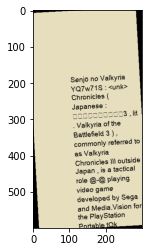

In [38]:
plt.imshow(dataset[0]['image'])

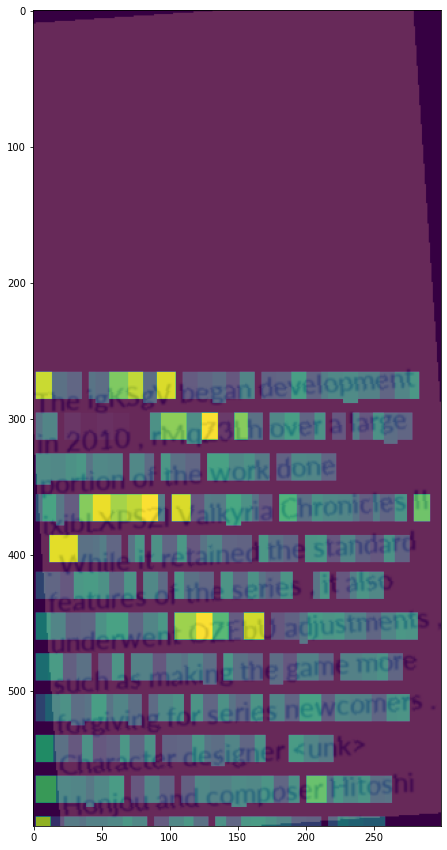

In [56]:
sample = dataset[1]

plt.figure(figsize=(15, 15))
plt.imshow(sample['image'])
plt.imshow(sample['mask'], alpha=0.8)

In [29]:
dataset.tokenizer.decode(sample['target'])

'The game began development in 2010, carrying over a large portion of the work done on Valkyria Chronicles II. While it retained the standard features of the series, it also underwent multiple adjustments, such as making the game more forgiving for series newcomers. Character designer ⁇  Honjou and composer Hitoshi Sakimoto both returned from previous'